# Bag of Visual Words

From https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/ with polished code

In [12]:
from src.phishIRISData import PhishIRISDataset
from src.config import config
from sklearn.model_selection import train_test_split

from src.SIFT_bovw import (
    read_bw_images,
    sift_features,
    get_visual_words,
    get_frequency_vectors,
    get_tfidf,
    search_test,
)


import joblib

In [13]:
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

In [14]:
k, codebook = joblib.load(config.PROCESSED_DATA_DIR / "bovw-codebook.pkl")

In [15]:
images_training, images_testing, labels_training, labels_testing = train_test_split(
    train_dataset.img_paths, train_dataset.labels, test_size=0.2, random_state=42
)

In [16]:
bw_images_train, bw_images_test = (
    read_bw_images(images_training),
    read_bw_images(images_testing),
)

In [17]:
keypoints_train, descriptors_train = sift_features(bw_images_train)
keypoints_test, descriptors_test = sift_features(bw_images_test)

len before: 1050
indexes: []
len after: 1050
len before: 263
indexes: []
len after: 263


In [18]:
joblib.dump(descriptors_train, config.PROCESSED_DATA_DIR / "bovw-train.pkl")
joblib.dump(descriptors_test, config.PROCESSED_DATA_DIR / "bovw-test.pkl")

['/Users/marcinjarczewski/src/phish-target-recognition/data/processed/bovw-test.pkl']

In [19]:
descriptors_train = joblib.load(config.PROCESSED_DATA_DIR / "bovw-train.pkl")
descriptors_test = joblib.load(config.PROCESSED_DATA_DIR / "bovw-test.pkl")

visual_words_train = get_visual_words(descriptors_train, codebook)
visual_words_test = get_visual_words(descriptors_test, codebook)

In [20]:
frequency_vectors_train = get_frequency_vectors(visual_words_train, k)
frequency_vectors_test = get_frequency_vectors(visual_words_test, k)

In [21]:
tfidf_train = get_tfidf(frequency_vectors_train)
tfidf_test = get_tfidf(frequency_vectors_test)

df.shape, df[:5]: (200,), [706 958 884 633 882]
idf.shape, idf[:5]: (200,), [0.39693021 0.09169767 0.17208838 0.50607502 0.17435339]
df.shape, df[:5]: (200,), [178 244 231 147 227]
idf.shape, idf[:5]: (200,), [0.39037048 0.07498581 0.12973632 0.58172145 0.14720401]


In [22]:
search_test(tfidf_test[0], tfidf_train)

(array([538, 489,  33,  81, 290]),
 array([0.98449263, 0.94872002, 0.89343473, 0.80111785, 0.75056325]))

In [25]:
print(labels_testing[0])
for idx, el in enumerate([538, 489, 33, 81, 290]):
    print(f"{idx}: {labels_training[el]}")

chase
0: chase
1: chase
2: chase
3: chase
4: dropbox


In [26]:
k1, d1 = sift_features([bw_images_test[15]])
vw1 = get_visual_words(d1, codebook)
fv1 = get_frequency_vectors(vw1, k)

len before: 1
indexes: []
len after: 1


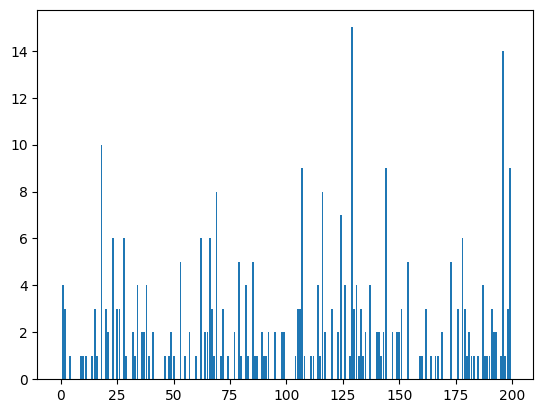

In [27]:
import matplotlib.pyplot as plt

plt.bar(list(range(k)), fv1[0])
plt.show()

Search image:


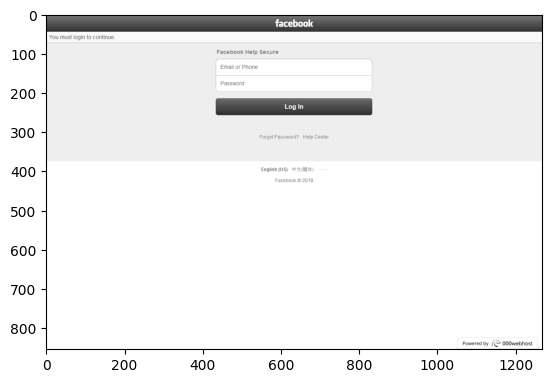

-----------------------------------------------------
556: 0.7848


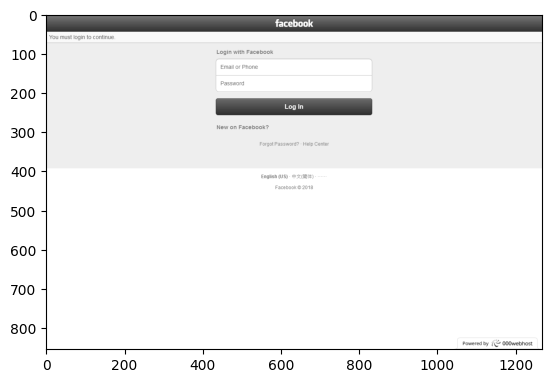

765: 0.7806


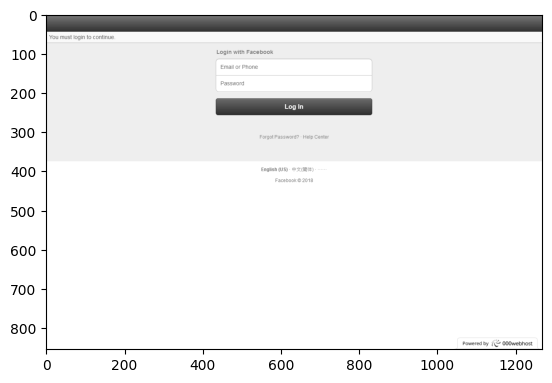

479: 0.7637


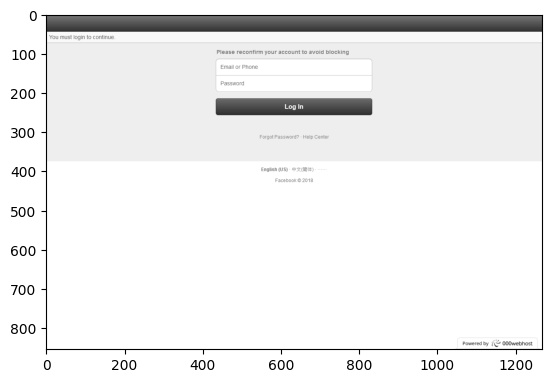

737: 0.7362


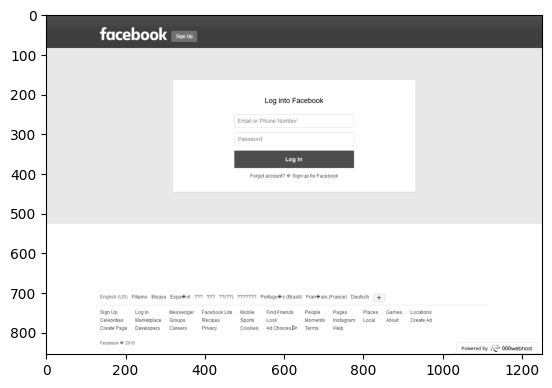

142: 0.7305


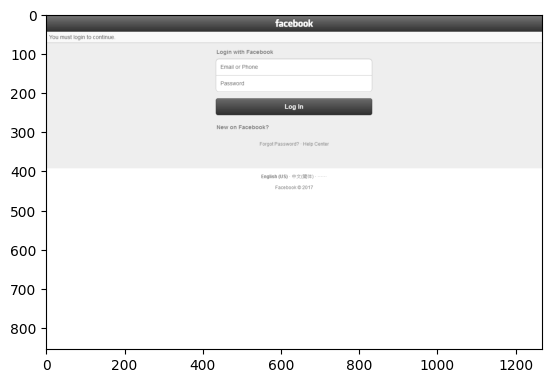

(array([556, 765, 479, 737, 142]),
 array([0.78477923, 0.78061429, 0.76370984, 0.73624876, 0.73052946]))

In [28]:
search_test(
    fv1[0], tfidf_train, search_image=bw_images_test[15], db_images=bw_images_train
)

In [30]:
labels_training[55], labels_testing[15]

('facebook', 'facebook')